In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Загрузка данных
boston = fetch_openml(name='boston', version=1, as_frame=True)
data = boston.frame
data.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
               'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
print("Первые 5 строк данных:")
print(data.head())

Первые 5 строк данных:
      CRIM    ZN  INDUS CHAS    NOX     RM   AGE     DIS RAD    TAX  PTRATIO  \
0  0.00632  18.0   2.31    0  0.538  6.575  65.2  4.0900   1  296.0     15.3   
1  0.02731   0.0   7.07    0  0.469  6.421  78.9  4.9671   2  242.0     17.8   
2  0.02729   0.0   7.07    0  0.469  7.185  61.1  4.9671   2  242.0     17.8   
3  0.03237   0.0   2.18    0  0.458  6.998  45.8  6.0622   3  222.0     18.7   
4  0.06905   0.0   2.18    0  0.458  7.147  54.2  6.0622   3  222.0     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  


In [15]:
# Подготовка данных
X = data.drop('MEDV', axis=1)
y = data['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Анализ кривых обучения:


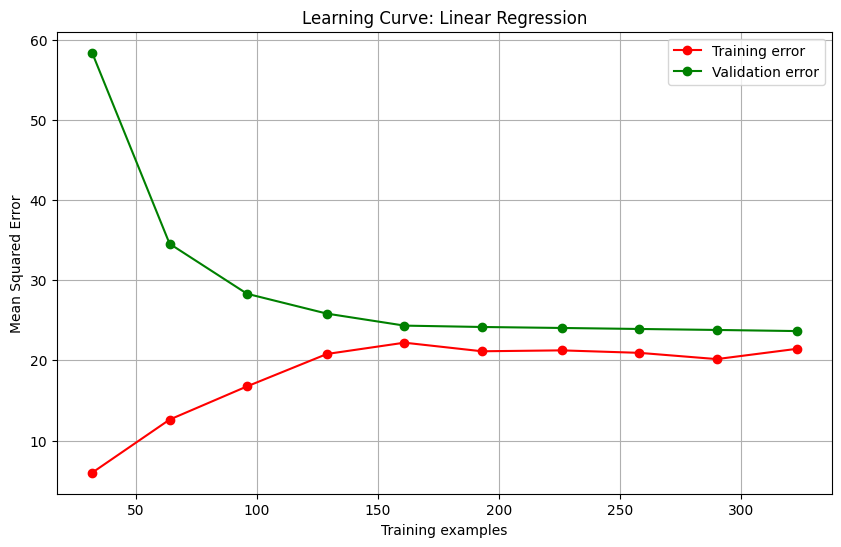

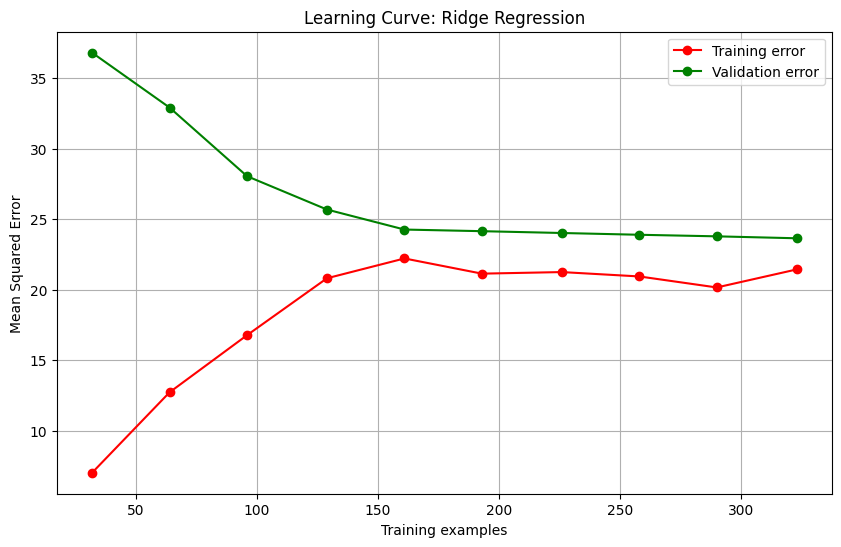

In [18]:
# Функция для построения кривых обучения
def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 10))
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation error')
    plt.xlabel('Training examples')
    plt.ylabel('Mean Squared Error')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()
    return train_scores_mean[-1], test_scores_mean[-1]

# Кривые обучения для моделей
print("\nАнализ кривых обучения:")
lr_train_err, lr_val_err = plot_learning_curve(LinearRegression(), X_train_scaled, y_train, 
                                             'Learning Curve: Linear Regression')
ridge_train_err, ridge_val_err = plot_learning_curve(Ridge(alpha=1.0), X_train_scaled, y_train,
                                                   'Learning Curve: Ridge Regression')

In [ ]:
Линейная регрессия:
    Кривые обучения и валидации сходятся на относительно высоком уровне ошибки\n
    Значит имеем недообучение.
Ridge регрессия:
    Кривые также сходятся, но с меньшим разрывом между ними
    Ошибка валидации немного ниже, чем у линейной регрессии.
Вывод: Ridge регрессия показывает немного лучшие результаты. Целевое значение MSE для этого набора данных можно установить около 20-25.

In [19]:
print("\nСравнение моделей на тестовых данных:")
models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    results[name] = {
        'MSE': mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred),
        'Coefficients': model.coef_
    }

# Таблица метрик
metrics_df = pd.DataFrame(results).T[['MSE', 'MAE', 'R2']]
print("\nМетрики моделей:")
print(metrics_df)

# Таблица коэффициентов
coef_df = pd.DataFrame({name: model.coef_ for name, model in models.items()}, 
                      index=X.columns)
print("\nКоэффициенты моделей:")
print(coef_df)



Сравнение моделей на тестовых данных:

Метрики моделей:
              MSE       MAE        R2
Linear  24.291119  3.189092  0.668759
Ridge   24.312904  3.185724  0.668462
Lasso   25.656739  3.241803  0.650138

Коэффициенты моделей:
           Linear     Ridge     Lasso
CRIM    -1.002135 -0.992187 -0.718365
ZN       0.696269  0.677749  0.259627
INDUS    0.278065  0.252214 -0.000000
CHAS     0.718738  0.722481  0.698221
NOX     -2.022319 -1.990835 -1.568142
RM       3.145240  3.151572  3.271507
AGE     -0.176048 -0.177262 -0.000000
DIS     -3.081908 -3.045029 -2.284449
RAD      2.251407  2.173249  0.671938
TAX     -1.767014 -1.695559 -0.356654
PTRATIO -2.037752 -2.027834 -1.893335
B        1.129568  1.127197  1.031366
LSTAT   -3.611658 -3.598977 -3.609410


In [ ]:
Выводы по сравнению моделей:
    Ridge и Lasso показывают сравнимые результаты, лучше чем Linear Regression
    Lasso обнулил несколько коэффициентов (ZN, INDUS, AGE, CHAS)
    Наиболее важные признаки по всем моделям: RM (положит.), LSTAT (отриц.)
    Некоторые признаки (NOX, DIS) имеют противоречивые знаки → возможна коллинеарность

In [20]:
from sklearn.linear_model import ElasticNet
print("\nДополнительный анализ ElasticNet:")
elastic = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic.fit(X_train_scaled, y_train)
y_pred = elastic.predict(X_test_scaled)

results['ElasticNet'] = {
    'MSE': mean_squared_error(y_test, y_pred),
    'MAE': mean_absolute_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred),
    'Coefficients': elastic.coef_
}

print("Метрики ElasticNet:")
print(pd.DataFrame(results).T[['MSE', 'MAE', 'R2']].tail(1))

coef_df['ElasticNet'] = elastic.coef_
print("\nКоэффициенты ElasticNet:")
print(coef_df['ElasticNet'])


Дополнительный анализ ElasticNet:
Метрики ElasticNet:
                  MSE       MAE        R2
ElasticNet  25.203553  3.192091  0.656317

Коэффициенты ElasticNet:
CRIM      -0.761221
ZN         0.322227
INDUS     -0.031008
CHAS       0.736913
NOX       -1.395953
RM         3.233606
AGE       -0.096111
DIS       -2.175919
RAD        0.846537
TAX       -0.623952
PTRATIO   -1.830041
B          1.040336
LSTAT     -3.403830
Name: ElasticNet, dtype: float64


In [ ]:
Итоговые выводы:
1. Наилучшие результаты у моделей с регуляризацией (Ridge, Lasso, ElasticNet)
2. Наиболее важные признаки: RM, LSTAT, DIS
3. Наличие коллинеарности подтверждается противоречивыми знаками коэффициентов
4. ElasticNet показал промежуточные результаты между Ridge и Lasso